# Problem Set 3
## UCSF NS248, Winter 2023

### Solutions by Max Collard

---

In [1]:
import itertools
import os

import numpy as np
import scipy.integrate as sint
import scipy.stats as sstats
import matplotlib.pyplot as plt

import astropy.stats as astats

from tqdm import tqdm

---

## Problem 1

1. Thoughtful (and fundable) experimental design requires power analyses, where one estimates the number of subjects or measurements required to have a reasonable chance of detecting a difference between or among groups. Suppose you plan to do a study where you want to compare the number of somatostatin positive (SOM+) neurons in the dentate gyrus (DG) region of the hippocampus across an older and a younger group of mice. You plan to perfuse them, cut sections, stain for somatostatin, and then count the number of positive cells for each animal. From previous studies you expect the there to be a mean of 5000 SOM+ DG interneurons in the younger animals, with a standard deviation of 1000. Assume the standard deviation is the same for the older group and that all of your measurements will be drawn from Gaussian distributions.

1.
a. How many animals would you need in each group to have an 80% of detecting, at a p<0.05 level, a difference in mean SOM+ interneuron number of 2000 (e.g. the older animals having a mean of 3000 interneurons)? Assume that you’ll use a two-sample t-test. This can be calculated analytically, but we suggest using simulations to answer this question.

### Helpers

*These are from last time:*

In [2]:
def simulate( group_ns, group_means, group_stds,
              method = 'np',
              n_points = 10000,
              n_std = 10 ):
    """Simulate groups of iid Gaussian draws with the given parameters
    
    Keyword arguments:
    * `method`: the random number generator method to use
        * `np` (default) uses `numpy` built-ins
        * `mine` uses the demo functions created for the above problems; this has
            the additional parameters `n_points` (the number of CDF points used for
            interpolation) and `n_std` (the number of standard deviations away from
            the mean to compute tails for the CDF)
    """
    
    # Check to see that all the groups have their parameters defined
    if group_means.keys() != group_stds.keys():
        raise ValueError( 'Malformed parameters.' )
    if group_ns.keys() != group_means.keys():
        raise ValueError( 'Malformed parameters.' )
    
    # Create random number generators for each group
    group_generators = dict()
    for group in group_means.keys():
        
        if method == 'np':
            # Use the `numpy` built-in random methods for speed
            # This defines a random generator function that has the same arguments as what I
            #   made in `random_generator`
            def gen( size = (1,) ):
                return np.random.normal( loc = group_means[group],
                                         scale = group_stds[group],
                                         size = size )
            group_generators[group] = gen
            
        elif method == 'mine':
            # I don't have all the other functions to define this here
            raise NotImplementedException()
    
    # Use the random number generators of whatever method to generate data for each group
    data = dict()
    for group, generator in group_generators.items():
        data[group] = generator( size = (group_ns[group],) )
    
    return data

def evaluate( data,
              test = sstats.ttest_ind ):
    """Return the p-value for the given `test` between all of the groups in the given `dict` of `data`
    
    (Default test is `scipy.stats.ttest_ind`)
    """
    
    # This ensures there is a unique (sorted) order to the groups
    groups = list( sorted( data.keys() ) )
    
    ret = dict()
    # Iterate across all possible comparisons between two groups
    for group_a, group_b in itertools.combinations( groups, 2 ):
        ret[(group_a, group_b)] = test( data[group_a], data[group_b] ).pvalue
    return ret

In [3]:
def estimate_power( group_ns, group_means, group_stds,
                    comparison_key = None,
                    test = sstats.ttest_ind,
                    alpha = 0.05,
                    n_runs = 10000,
                    verbose = False,
                    **kwargs ):
    """Estimate the power of a test for comparing two normally-distributed samples with the given parameters"""
    
    # TODO Should ierate overall comparisons
    if comparison_key is None:
        all_keys = list( sorted( group_ns.keys() ) )
        comparison_key = (all_keys[0], all_keys[1])
    
    # Make it so that we can switch on the progress bars if we want
    it = range( n_runs )
    if verbose:
        it = tqdm( it )
    
    ps_comparison = []
    for i_run in it:
        run_ps = evaluate( simulate( group_ns, group_means, group_stds, **kwargs ),
                           test = test )
        ps_comparison.append( run_ps[comparison_key] )
    ps_comparison = np.array( ps_comparison )
    
    # Power is the fraction of runs that reject
    return np.sum( ps_comparison < alpha ) / n_runs

### Parameters

In [4]:
group_means = {
    'Young': 5000,
    'Old': 3000,
}

group_stds = {
    'Young': 1000,
    'Old': 1000,
}

n_runs_each = 1000

### Run

In [5]:
n_cur = 2

ns_test = []
powers_test = []

while True:
    
    group_ns = {
        'Young': n_cur,
        'Old': n_cur,
    }
    
    power_cur = estimate_power( group_ns, group_means, group_stds,
                                n_runs = n_runs_each )
    
    ns_test.append( n_cur )
    powers_test.append( power_cur )
    
    if power_cur >= 0.8:
        break
    
    n_cur += 1
    
ns_power_curve = np.array( ns_test )
powers_power_curve = np.array( powers_test )

### Plotting

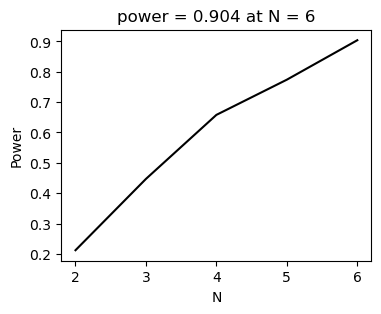

In [6]:
plt.figure( figsize = (4, 3) )
plt.plot( ns_power_curve, powers_power_curve, 'k-' )
plt.xlabel( 'N' )
plt.ylabel( 'Power' )

plt.title( f'power = {powers_power_curve[-1]:0.3f} at N = {ns_power_curve[-1]}' )

plt.show()

1. b. Repeat for expected differences of 100, 500, and 1000, and plot the number of animals required vs. the expected difference.

### Helpers

In [7]:
def get_threshold_n_linear( group_means, group_stds,
                            target_power = 0.8,
                            **kwargs ):
    """Steps through each n in sequence
    
    kwargs are passed to `estimate_power`
    """
    
    n_cur = 2
    while True:
        
        group_ns = {
            'Young': n_cur,
            'Old': n_cur,
        }
        
        power_cur = estimate_power( group_ns, group_means, group_stds, **kwargs )
        
        if power_cur >= target_power:
            break
        n_cur += 1
        
    return n_cur

def get_threshold_n_jumpy( group_means, group_stds,
                           target_power = 0.8,
                           jump = 100,
                           **kwargs ):
    """Jumps the n by `jump`, then halves the jump when it goes too far
    
    kwargs are passed to `estimate_power`
    """
    
    cur_jump = jump
    
    n_cur = 2
    while True:
        
        group_ns = {
            'Young': n_cur,
            'Old': n_cur,
        }
        
        power_cur = estimate_power( group_ns, group_means, group_stds, **kwargs )
        
        if power_cur >= target_power:
            if cur_jump == 1:
                # If we've gotten to the stepping by one phase, then we're at the end
                break
            
            # Our step was larger, so we want to "re-do".
            # Step back to previous location, then step forward by new jump of half the size
            n_cur = n_cur - cur_jump
            cur_jump = cur_jump // 2
        n_cur += cur_jump
    
    return n_cur

### Parameters

In [8]:
group_stds = {
    'Young': 1000,
    'Old': 1000,
}

params = {
    'n_runs': 500,
}

differences_test = [100, 500, 1000, 2000]

### Run

In [9]:
threshold_ns_test = []
for difference in differences_test:
    
    group_means = {
        'Young': 5000,
        'Old': 5000 - difference
    }
    
    print( f'Getting n for difference = {difference}...', end = '' )
    threshold_n_cur = get_threshold_n_jumpy( group_means, group_stds, **params )
    threshold_ns_test.append( threshold_n_cur )
    print( 'Done.' )
    
differences_n_curve = np.array( differences_test )
threshold_ns_n_curve = np.array( threshold_ns_test )

Getting n for difference = 100 ...Done.
Getting n for difference = 500 ...Done.
Getting n for difference = 1000 ...Done.
Getting n for difference = 2000 ...Done.


### Plotting

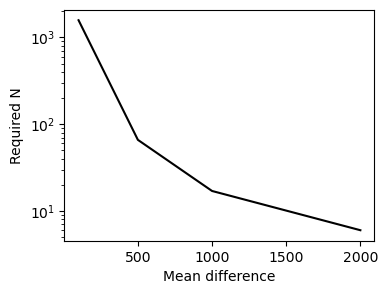

In [10]:
plt.figure( figsize = (4, 3) )

plt.semilogy( differences_n_curve, threshold_ns_n_curve, 'k-' )

plt.xlabel( 'Mean difference' )
plt.ylabel( 'Required N' )

plt.show()

1. c. Now suppose you find a new study which suggests the standard deviation of the count in young animals is actually 500, not 1000. Repeat a. and b., and compare the results given the different values of the expected standard deviation.

### Parameters

*Forgive the code duplication, I was in a hurry 😬*

In [59]:
group_means = {
    'Young': 5000,
    'Old': 3000,
}

group_stds_new = {
    'Young': 500,
    'Old': 500,
}

# For power curve
n_runs_each = 1000

# For N curve
differences_test = [100, 500, 1000, 2000]
params = {
    'n_runs': 200,
}

### Run 1a

In [60]:
n_cur = 2

ns_test = []
powers_test = []

while True:
    
    group_ns = {
        'Young': n_cur,
        'Old': n_cur,
    }
    
    power_cur = estimate_power( group_ns, group_means, group_stds_new,
                                n_runs = n_runs_each )
    
    ns_test.append( n_cur )
    powers_test.append( power_cur )
    
    if power_cur >= 0.8:
        break
    
    n_cur += 1
    
ns_power_curve_new = np.array( ns_test )
powers_power_curve_new = np.array( powers_test )

### Plotting 1b

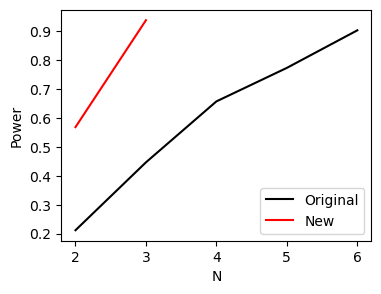

In [61]:
plt.figure( figsize = (4, 3) )

plt.plot( ns_power_curve, powers_power_curve, 'k-', label = 'Original' )
plt.plot( ns_power_curve_new, powers_power_curve_new, 'r-', label = 'New' )
plt.xlabel( 'N' )
plt.ylabel( 'Power' )

plt.legend()

plt.show()

### Run 1b

In [62]:
threshold_ns_test = []
for difference in differences_test:
    
    group_means = {
        'Young': 5000,
        'Old': 5000 - difference
    }
    
    print( f'Getting n for difference = {difference} ...', end = '' )
    threshold_ns_test.append( get_threshold_n_jumpy( group_means, group_stds_new, **params ) )
    print( 'Done.' )
    
differences_n_curve_new = np.array( differences_test )
threshold_ns_n_curve_new = np.array( threshold_ns_test )

Getting n for difference = 100 ...Done.
Getting n for difference = 500 ...Done.
Getting n for difference = 1000 ...Done.
Getting n for difference = 2000 ...Done.


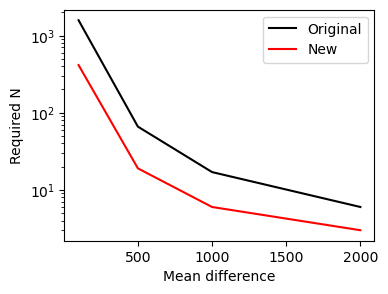

In [63]:
plt.figure( figsize = (4, 3) )

plt.semilogy( differences_n_curve, threshold_ns_n_curve, 'k-', label = 'Original' )
plt.semilogy( differences_n_curve_new, threshold_ns_n_curve_new, 'r-', label = 'New' )

plt.xlabel( 'Mean difference' )
plt.ylabel( 'Required N' )

plt.legend()

plt.show()

---

## Problem 2

2. Suppose that you are doing a behavioral experiment where you are measuring the latency of different groups of animals to enter the middle of an open field environment. Your goal is to determine, for each dataset, whether the groups differ from one another. Make sure you are clear on exactly what difference between the groups you are testing for in each case and what a significant difference would mean.

    For each of the datasets below, each row has two values: the group number (1 or 2) and the latency measure for the animal (a time in seconds). For each dataset, do the following:
    1. Read in the data (`numpy.loadtxt()` works well)
    2. Plot histograms of the data from each group.
    3. Determine what sort of statistical test is appropriate for the data and explain why that test is appropriate.
    4. Carry out the test and report whether you would or would not claim that the groups have different escape latencies. If you decide a non-parametric test is appropriate, report the results from the parametric test as well for comparison and explain any differences between them.

### Helpers

In [16]:
def pipeline_2( path,
                hist_bins = None,
                normality_alpha = 0.05,
                equal_var_alpha = 0.05,
                alpha = 0.05 ):
    
    # Parse parameters
    if hist_bins is None:
        hist_bins = np.arange( 0, 71, 5. )
    
    # 1.
    # Load data
    
    data = np.loadtxt( path )
    
    labels = data[:, 0]
    values = data[:, 1]
    
    # 2.
    # Plot data
    
    plt.figure( figsize = (5, 3) )
    
    plt.hist( values[labels == 1],
              bins = hist_bins,
              alpha = 0.5,
              label = 'Group 1' )
    plt.hist( values[labels == 2],
              bins = hist_bins,
              alpha = 0.5,
              label = 'Group 2' )
    
    plt.title( path )
    plt.legend()
    
    plt.show()
    
    # 3.
    # Determine whether to use parametric stats
    
    normal_gof_1 = sstats.normaltest( values[labels == 1] )
    normal_gof_2 = sstats.normaltest( values[labels == 2] )
    
    use_parametric = True
    if normal_gof_1.pvalue < normality_alpha:
        print( f'Group 1 rejects normality (p = {normal_gof_1.pvalue}' )
        use_parametric = False
    if normal_gof_2.pvalue < normality_alpha:
        print( f'Group 2 rejects normality (p = {normal_gof_2.pvalue}' )
        use_parametric = False
        
    # 4.
    # Do the tests
    
    # Perform parametric tests no matter what, as asked in the problem
    
    # Determine if equal variance is appropriate
    equal_var = True
    equal_var_result = sstats.levene( values[labels == 1], values[labels == 2] )
    if equal_var_result.pvalue < equal_var_alpha:
        print( f'Groups 1 and 2 have separable variances (p = {equal_var_result.pvalue})' )
        equal_var = False

    test_result = sstats.ttest_ind( values[labels == 1], values[labels == 2],
                                    equal_var = equal_var )
    if test_result.pvalue < alpha:
        if use_parametric:
            print( f'** REJECT (p = {test_result.pvalue})' )
            return True
        else:
            print( f'(Hypothetical parametric result: Reject (p = {test_result.pvalue})' )
    else:
        if use_parametric:
            print( f'** DO NOT REJECT (p = {test_result.pvalue})' )
            return False
        else:
            print( f'(Hypothetical parametric result: Do not reject (p = {test_result.pvalue})' )
    
    # From here on out, we are for sure in the nonparametric regime (because of the returns above)
    
    test_result = sstats.ranksums( values[labels == 1], values[labels == 2] )
    
    if test_result.pvalue < alpha:
        print( f'** REJECT (p = {test_result.pvalue})' )
        return True
    print( f'** DO NOT REJECT (p = {test_result.pvalue})' )
    return False

### Parameters

In [17]:
data_dir = 'data'
filenames = [
    'PS3_dataset1.txt',
    'PS3_dataset2.txt',
    'PS3_dataset3.txt',
    'PS3_dataset4.txt',
]

### Run

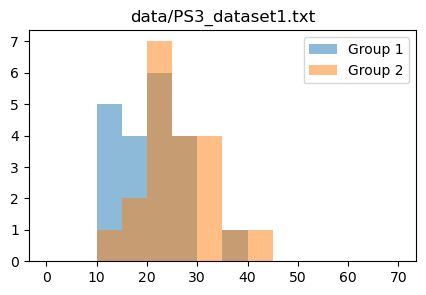

** REJECT (p = 0.025681133229641724)


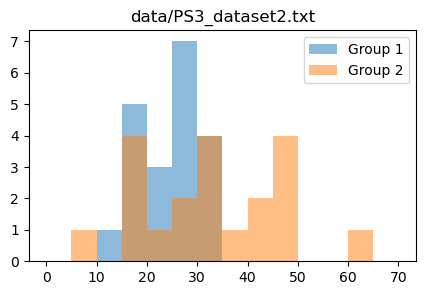

Groups 1 and 2 have separable variances (p = 0.0018432697962879683)
** REJECT (p = 0.02301298320933342)


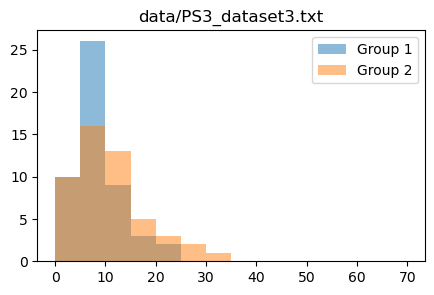

Group 1 rejects normality (p = 0.0009121638635692444
Group 2 rejects normality (p = 0.0005238732081696317
Groups 1 and 2 have separable variances (p = 0.010467078365753951)
(Hypothetical parametric result: Reject (p = 0.02376762749598984)
** DO NOT REJECT (p = 0.07530445719468767)


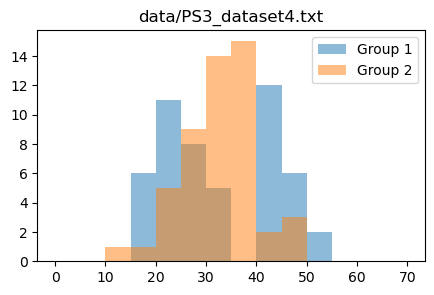

Group 1 rejects normality (p = 3.4032065677896554e-05
Groups 1 and 2 have separable variances (p = 0.0011972101774486482)
(Hypothetical parametric result: Do not reject (p = 0.9670407072666372)
** DO NOT REJECT (p = 0.6943580856027296)


In [18]:
for filename in filenames:
    pipeline_2( os.path.join( data_dir, filename ) )

This last one is a good demo: we could probably separate it with a KS test, but this would be a different statistical statement!

---

## Problem 3

3. Suppose you are interested in testing whether a potential anxiolytic drug changes latencies in the same experimental setup as problem 2 above. You collect data from animals given either the drug or a saline control injection, and for this dataset (PS3_dataset5.txt), 1 in the first column represents the animal number, the second the condition (1 for saline, 2 for drug) and the third the latency. Repeat instructions 1-4 from Problem 2 for these data, modifying as you feel is appropriate for this dataset. Would you conclude that it is likely that the drug has an effect?

### Helpers

In [56]:
def pipeline_3( path,
                hist_bins = None,
                normality_alpha = 0.05,
                equal_var_alpha = 0.05,
                alpha = 0.05 ):
    
    # Parse parameters
    if hist_bins is None:
        hist_bins = np.arange( 0, 71, 5. )
    
    # 1.
    # Lod data
    
    data = np.loadtxt( path )
    
    labels = data[:, 0]
    conditions = data[:, 1]
    values = data[:, 2]
    
    # Make sure to align mouse labels
    labels_all = list( sorted( set( labels ) ) )
    values_paired_1 = np.array( [ values[(labels == l) & (conditions == 1)][0]
                                for l in labels_all ] )
    values_paired_2 = np.array( [ values[(labels == l) & (conditions == 2)][0]
                                for l in labels_all ] )
    
    # 2.
    # Plot data
    
    plt.figure( figsize = (5, 3) )
    
    plt.hist( values_paired_1,
              bins = hist_bins,
              alpha = 0.5,
              label = 'Group 1' )
    plt.hist( values_paired_2,
              bins = hist_bins,
              alpha = 0.5,
              label = 'Group 2' )
    
    plt.title( path )
    plt.legend()
    
    plt.show()
    
    plt.figure( figsize = (2, 3) )
    
    # Spread out the x-coordinates of the plotted data a little bit
    xs_1 = 0. + 0.05 * np.random.normal( size = values_paired_1.shape )
    xs_2 = 1. + 0.05 * np.random.normal( size = values_paired_2.shape )
    
    for x1, x2, y1, y2 in zip( xs_1, xs_2, values_paired_1, values_paired_2 ):
        plt.plot( [x1, x2], [y1, y2], 'k-',
                  alpha = 0.3,
                  linewidth = 1 )
    
    plt.plot( xs_1, values_paired_1, 'C0.',
              markersize = 5 )
    plt.plot( xs_2, values_paired_2, 'C1.',
              markersize = 5 )
    
    plt.xlim( -0.5, 1.5 )
    plt.xticks( [0, 1], ['Group 1', 'Group 2'] )
    
    plt.title( path )
    
    plt.show()
    
    # 3.
    # Decide if we should use a parametric or nonparametric test
    
    normal_gof_diff = sstats.normaltest( values_paired_2 - values_paired_1 )
    
    use_parametric = True
    if normal_gof_diff.pvalue < normality_alpha:
        print( f'Group differences rejects normality (p = {normal_gof_diff.pvalue}' )
        use_parametric = False
        
    # 4.
    # Run the appropriate test

    test_result = sstats.ttest_rel( values_paired_1, values_paired_2 )
    if test_result.pvalue < alpha:
        if use_parametric:
            print( f'** REJECT (p = {test_result.pvalue})' )
            return True
        else:
            print( f'(Hypothetical parametric result: Reject (p = {test_result.pvalue})' )
    else:
        if use_parametric:
            print( f'** DO NOT REJECT (p = {test_result.pvalue})' )
            return False
        else:
            print( f'(Hypothetical parametric result: Do not reject (p = {test_result.pvalue})' )
    
    # From here on out, we are for sure in the nonparametric regime
    
    test_result = sstats.wilcoxon( values_paired_1, values_paired_2 )
    
    if test_result.pvalue < alpha:
        print( f'** REJECT (p = {test_result.pvalue})' )
        return True
    print( f'** DO NOT REJECT (p = {test_result.pvalue})' )
    return False

### Parameters

In [57]:
data_dir = 'data'
filenames = [
    'PS3_dataset5.txt',
]

### Run

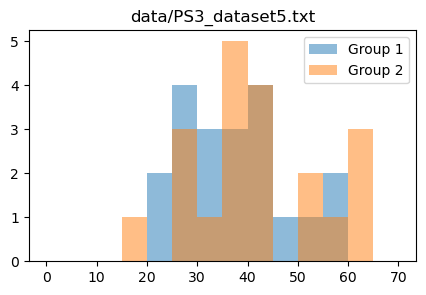

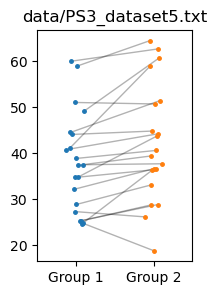

** REJECT (p = 0.002262772291428005)


In [58]:
for filename in filenames:
    pipeline_3( os.path.join( data_dir, filename ) )

Note that, although the distributions look like they overlap substantially overall (first plot), the **paired** test can detect that there is a nonzero effect for the **differences** (second plot).

---

## Problem 4

4. Spike trains can be analyzed with respect to brain or behavioral rhythms. Suppose that you’ve collected spikes from two neurons (500 spikes each). Suppose you have also recorded the phase of the whisking cycle, where a phase of 0 corresponds to when the whisker is fully anterior and a phase of pi corresponds to when the whisker is at its fully posterior position. PS3_dataset6.txt contains the phases of each spike, where the first column corresponds to the neuron number (1 or 2) and the second to the phase of the spike.

4. a. Use np.hist (or matlab’s histogram command) to create a histogram of spike counts in phase bins of width pi/12 for each cell. Does either cell appear to be more active at some phases rather than others?

In [22]:
data_dir = 'data'
filename = 'PS3_dataset6.txt'
path = os.path.join( data_dir, filename )

data = np.loadtxt( path )
    
labels = data[:, 0]
values = data[:, 1]

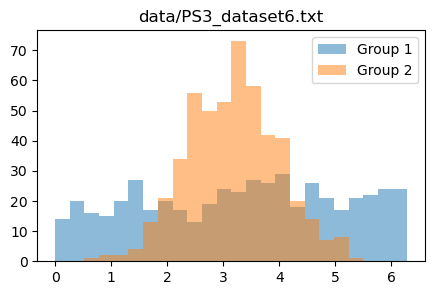

In [23]:
hist_bins = np.arange( 0, 2 * np.pi + 0.01, np.pi / 12. )

plt.figure( figsize = (5, 3) )
    
plt.hist( values[labels == 1],
          bins = hist_bins,
          alpha = 0.5,
          label = 'Group 1' )
plt.hist( values[labels == 2],
          bins = hist_bins,
          alpha = 0.5,
          label = 'Group 2' )

plt.title( path )
plt.legend()

plt.show()

I'm guessing neuron 2 is tuned and neuron 1 isn't.

4. b. Bonus: The Rayleigh test can be used to determine whether a set of phases can be differentiated from a uniform circular distribution. See if you can find a python or Matlab function that runs the test, install it, and determine whether you can reject the null hypothesis of uniformity for either of the distributions.

In [24]:
rayleigh_result_1 = astats.rayleightest( values[labels == 1] )
print( f'Group 1: p = {rayleigh_result_1}' )

Group 1: p = 0.0957249106438036


In [25]:
rayleigh_result_2 = astats.rayleightest( values[labels == 2] )
print( f'Group 2: p = {rayleigh_result_2}' )

Group 1: p = 8.2984016701742e-115
